<h1><center>Machine Learning In Financial Industry</center></h1>                                      
  

<h1><center>May 06, 2022</center></h1>
<h1><center>Abstract</center></h1>




This report introduces the topic of Neural Network particularly Long short-term memory and its application to financial time series classification. By modelling asset prices with an economic link in common, it is sometimes possible to arrive at a stationary spread whose properties can be used to reduce exposure to systematic risk. Time series classification has been there in the literature for a while now. There are traditional statistical methods which can be used to do time series analysis.
One of the alternatives which has proven to be best is using recurrent neural networks (RNN).
We will be implementing Long short-term memory classification to predict the direction of the S & P 500 index.

# Contents

1. Introduction <br>
  1.1 Deep Learning <br>
  1.2 Recurrent Neural Network <br>
  1.3 Long Short Term Memory Network <br>

2. Problem Statement 

3. Many-to-One Sequence Problem

4. Importing the data and feature engineering

5. Self Organizing Maps (SOM)

6. Kmeans

7. Decision Tree Classifier

8. Long Short Term Memory Network (LSTM) <br>
  8.1 Multi layer model  <br>
  8.2 Grid Search (Parameter optimization)

9. Conclusion

10. Reference

# 1. Introduction 

# 1.1 Deep Learning 

▪ Inspired from our understanding of human brains <br>
▪ Layered or Hierarchical representations learning <br>
▪ “deep” in deep learning stands for successive layers of representations <br>
▪ Layered representations are learned via models called neural network <br>
▪ Neural networks are structured layers stacked on top of each other <br>
▪ Mathematical framework for learning representations from data <br>

Building blocks of Deep Learning  <br>
 ▪ Perceptron <br>
 ▪ Forward Propagation <br>
 ▪ Activation Functions <br>
 ▪ Weight Initialization <br>
 ▪ Backpropagation <br>

# 1.2 Recurrent Neural Network

Recurrent Neural Network (RNN) generalize the feedforward neural network with an internal memory state and good at modeling sequence data as it uses sequential memory for prediction. Sequential memory is a mechanism used to identify the sequence patterns. RNNs are faster and use less computational resources as there are less tensor operations. Sequence problems can be broadly categorized into the following types

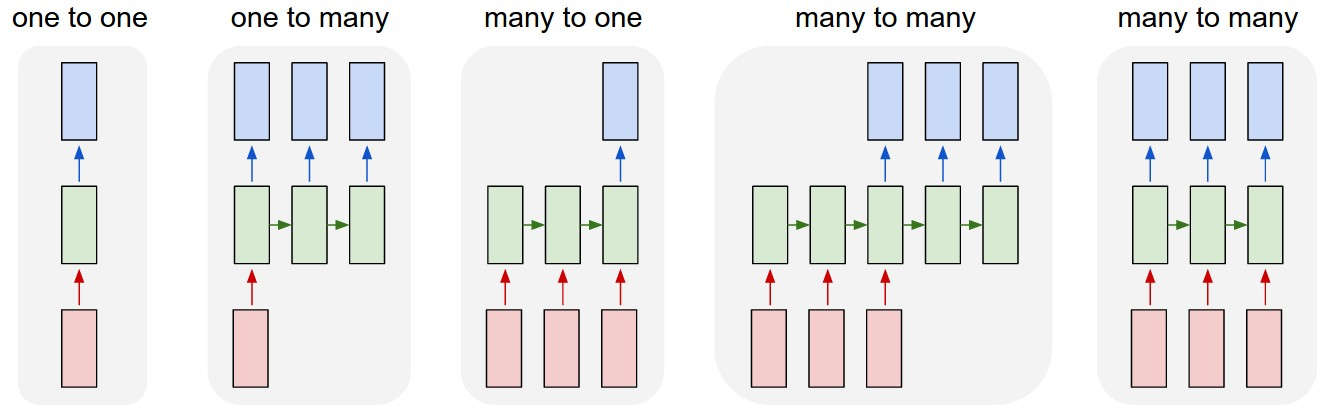

In [1]:
from IPython.display import Image
Image(filename='many_to_one.jpg')

For this project it's many to one as we will be having more than 30+ features and the final output is classification (1/0)

# 1.3 Long Short Term Memory Network (LSTM)


Long Short Term Memory (LSTM) algorithm is a special kind of RNN, explicitly designed to avoid the long-term dependency problem by addressing the problem of short term memory. LSTM models are fundamental to deep learning for financial timeseries and have four interacting layers as given below

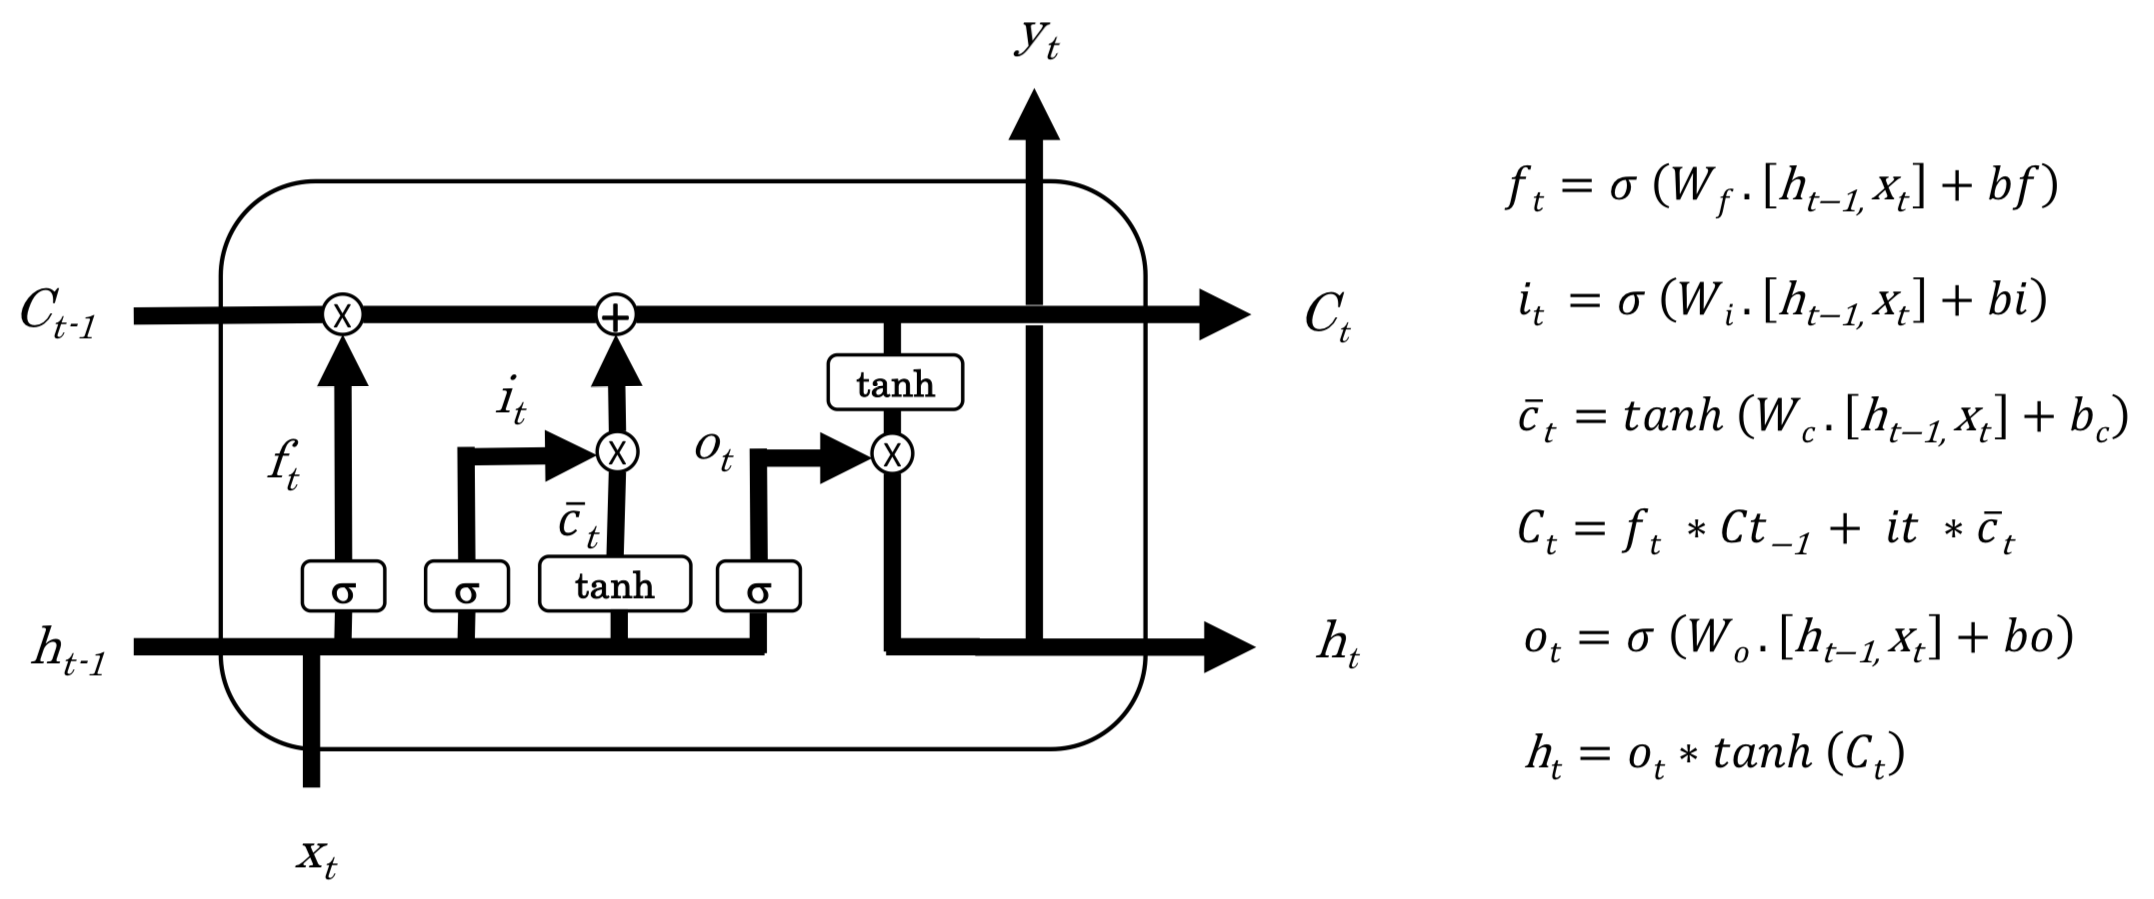

In [2]:
Image(filename='lstm.png')

# 2. Problem Statement

Build Long Short-term Memory model which can predict the decision of buying (signal=1) or hold (signal=0) for ETF index or any other financial time series.
I have taken S & P 500 index (with 30 years of historical daily data). 

# 3. Many-to-One Sequence Problem

The input of the LSTM is always a 3D array [batch, timesteps, feature]
The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument

If return_sequence is False, the output is a 2D array [batch, feature]
If return_sequence is True, the output is a 3D array [batch, timesteps, feature]

 ▪ batch is the number of samples in the input data <br>
 ▪ timesteps are the number of timesteps per sample <br>
 ▪ feature correspond to the number of features per timestep <br>

# 4. Importing the data and feature engineering 

# 4.1 Importing the data

below are commented, these are to install and upgrade few of the important libraries

In [3]:
#!pip install --upgrade scikit-learn
#!pip install minisom
#!pip install ta
#!pip install pandas_ta
#!pip install yfinance
#!pip install graphviz
#!pip install pydotplus

In [ ]:
# importing all the necessary libraries

import numpy as np
import pandas as pd
from pathlib import Path
import requests
import lxml
import yfinance as yf
import ta
import pandas_ta as pd_ta

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from ta import add_all_ta_features
from ta.utils import dropna
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Fetching Historical data of S&P 500, time period used is from 1990 to 2019 (30 years of daily prices)

In [5]:
SP_500 = yf.download('^GSPC',start='1990-01-01',end='2019-12-31',progress=False)

Exploratory Data Analysis (EDA)

In [6]:
SP_500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000


In [7]:
SP_500.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7558.000000,7558.000000,7558.000000,7558.000000,7558.000000,7.558000e+03
mean,1266.229035,1273.454384,1258.491763,1266.497917,1266.497917,2.186551e+09
std,672.017475,674.418212,669.340104,672.050505,672.050505,1.758622e+09
min,295.450012,301.450012,294.510010,295.459991,295.459991,1.499000e+07
25%,809.372513,819.087494,801.102509,811.145020,811.145020,5.144350e+08
50%,1191.434998,1198.765015,1184.484985,1191.534973,1191.534973,1.665000e+09
75%,1487.902527,1497.674957,1479.265045,1489.047516,1489.047516,3.547235e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.145623e+10


In [8]:
# checking if there is any null entries 
SP_500.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

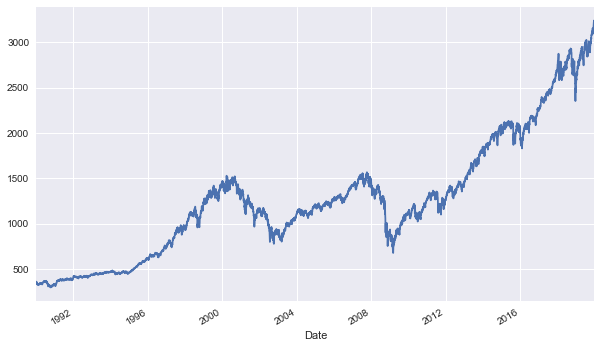

In [9]:
# plotting the adjusted closing price

SP_500['Adj Close'].plot(figsize=(10, 6));

In [10]:
# let's make a copy of original dataset 
df = SP_500.copy()
df.rename(columns = {'Adj Close' : 'price'}, inplace = True)
# feature engineering, based on the knowledge of our financial industry let's create some new meaningful features 
# which can help in predicting the direction of return in short terms (1D)

# 4.2 Feature Engineering 

features related to return of adjusted closing price

In [11]:
df['return'] = df['price'].pct_change()
df['return_2d'] = df['price'].pct_change(2)
df['return_3d'] = df['price'].pct_change(3)
df['return_1w'] = df['price'].pct_change(5)
df['return_2w'] = df['price'].pct_change(10)
df['return_3w'] = df['price'].pct_change(15)
df['return_1m'] = df['price'].pct_change(20)
df['return_5w'] = df['price'].pct_change(25)
df['return_6w'] = df['price'].pct_change(30)
df['return_7w'] = df['price'].pct_change(35)
df['return_2m'] = df['price'].pct_change(40)
df['return_9w'] = df['price'].pct_change(45)
df['return_10w'] = df['price'].pct_change(50)
df['return_3m'] = df['price'].pct_change(60)
df['return_15w'] = df['price'].pct_change(75)
df['return_4m'] = df['price'].pct_change(80)
df['return_18w'] = df['price'].pct_change(90)
df['return_5m'] = df['price'].pct_change(100)
df['return_6m'] = df['price'].pct_change(120)
df['return_7m'] = df['price'].pct_change(140)
df['return_8m'] = df['price'].pct_change(160)
df['return_9m'] = df['price'].pct_change(180)
df['return_10m'] = df['price'].pct_change(200)
df['return_11m'] = df['price'].pct_change(220)
df['return_12m'] = df['price'].pct_change(240)

moving average features

In [12]:
df['MA_2d']=df['price'].rolling(2).mean()
df['MA_5d']=df['price'].rolling(5).mean()
df['MA_10d']=df['price'].rolling(10).mean()
df['MA_15d']=df['price'].rolling(15).mean()
df['MA_1m']=df['price'].rolling(20).mean()
df['MA_2m']=df['price'].rolling(40).mean()
df['MA_3m']=df['price'].rolling(60).mean()
df['MA_4m']=df['price'].rolling(80).mean()
df['MA_5m']=df['price'].rolling(100).mean()
df['MA_6m']=df['price'].rolling(120).mean()
df['MA_7m']=df['price'].rolling(140).mean()
df['MA_8m']=df['price'].rolling(160).mean()
df['MA_9m']=df['price'].rolling(180).mean()
df['MA_10m']=df['price'].rolling(200).mean()
df['MA_11m']=df['price'].rolling(220).mean()
df['MA_12m']=df['price'].rolling(240).mean()

different lookback period for RSI in days 

In [13]:
df["rsi_5"]=pd_ta.rsi(df.Close,5)
df["rsi_10"]=pd_ta.rsi(df.Close,10)
df["rsi_21"]=pd_ta.rsi(df.Close,21,fillna=0)
df["rsi_50"]=pd_ta.rsi(df.Close,50,fillna=0)
df["rsi_200"]=pd_ta.rsi(df.Close,200,fillna=0)
df["rsi_250"]=pd_ta.rsi(df.Close,250,fillna=0)

stochastic with different K values

In [14]:
df=pd.concat([df, pd_ta.stoch(df.High,df.Low,df.Close,k=5)], axis=1)
df=pd.concat([df, pd_ta.stoch(df.High,df.Low,df.Close,k=10)], axis=1)
df=pd.concat([df, pd_ta.stoch(df.High,df.Low,df.Close,k=21)], axis=1)

CCI lookback features

In [15]:
df['cci_5']=pd_ta.cci(df.High,df.Low,df.Close,length=5,fillna=0)
df['cci_10']=pd_ta.cci(df.High,df.Low,df.Close,length=10,fillna=0)
df['cci_21']=pd_ta.cci(df.High,df.Low,df.Close,length=21,fillna=0)
df['cci_50']=pd_ta.cci(df.High,df.Low,df.Close,length=50,fillna=0)
df['cci_200']=pd_ta.cci(df.High,df.Low,df.Close,length=200,fillna=0)

MACD lookback features

In [16]:
df['macd_signal_5']=pd_ta.macd(df.Close,fast=5,slow=26,signal=5,fillna=0).iloc[:,1]
df['macd_signal_10']=pd_ta.macd(df.Close,fast=5,slow=26,signal=10,fillna=0).iloc[:,1]
df['macd_signal_21']=pd_ta.macd(df.Close,fast=5,slow=26,signal=21,fillna=0).iloc[:,1]
df['macd_signal_50']=pd_ta.macd(df.Close,fast=5,slow=26,signal=50,fillna=0).iloc[:,1]
df['macd_signal_200']=pd_ta.macd(df.Close,fast=5,slow=26,signal=200,fillna=0).iloc[:,1]

ATR lookback features

In [17]:
df['cci_5']=pd_ta.atr(df.High,df.Low,df.Close,length=5,fillna=0)
df['cci_10']=pd_ta.atr(df.High,df.Low,df.Close,length=10,fillna=0)
df['cci_21']=pd_ta.atr(df.High,df.Low,df.Close,length=21,fillna=0)
df['cci_50']=pd_ta.atr(df.High,df.Low,df.Close,length=50,fillna=0)
df['cci_200']=pd_ta.atr(df.High,df.Low,df.Close,length=200,fillna=0)

accbands lookback features

In [18]:
df['accbands_5']=pd_ta.accbands(df.High,df.Low,df.Close,length=5,fillna=0).iloc[:,1]
df['accbands_10']=pd_ta.accbands(df.High,df.Low,df.Close,length=10,fillna=0).iloc[:,1]
df['accbands_21']=pd_ta.accbands(df.High,df.Low,df.Close,length=21,fillna=0).iloc[:,1]
df['accbands_50']=pd_ta.accbands(df.High,df.Low,df.Close,length=50,fillna=0).iloc[:,1]
df['accbands_200']=pd_ta.accbands(df.High,df.Low,df.Close,length=200,fillna=0).iloc[:,1]

exponential weighted volume 

In [19]:
df['vol_ewm_5']=df['Volume'].ewm(5, adjust=False).mean()
df['vol_ewm_10']=df['Volume'].ewm(10, adjust=False).mean()
df['vol_ewm_21']=df['Volume'].ewm(21, adjust=False).mean()
df['vol_ewm_50']=df['Volume'].ewm(50, adjust=False).mean()
df['vol_ewm_200']=df['Volume'].ewm(200, adjust=False).mean()

exponential weighted moving average features

In [20]:
df['EMA_2d']=df['price'].ewm(2, adjust=False).mean()
df['EMA_5d']=df['price'].ewm(5, adjust=False).mean()
df['EMA_10d']=df['price'].ewm(10, adjust=False).mean()
df['EMA_15d']=df['price'].ewm(15, adjust=False).mean()
df['EMA_1m']=df['price'].ewm(20, adjust=False).mean()
df['EMA_2m']=df['price'].ewm(40, adjust=False).mean()
df['EMA_3m']=df['price'].ewm(60, adjust=False).mean()
df['EMA_4m']=df['price'].ewm(80, adjust=False).mean()
df['EMA_5m']=df['price'].ewm(100, adjust=False).mean()
df['EMA_6m']=df['price'].ewm(120, adjust=False).mean()
df['EMA_7m']=df['price'].ewm(140, adjust=False).mean()
df['EMA_8m']=df['price'].ewm(160, adjust=False).mean()
df['EMA_9m']=df['price'].ewm(180, adjust=False).mean()
df['EMA_10m']=df['price'].ewm(200, adjust=False).mean()
df['EMA_11m']=df['price'].ewm(220, adjust=False).mean()
df['EMA_12m']=df['price'].ewm(240, adjust=False).mean()


In [21]:
# Function to calculate average true range
def ATR(dataframe, period=21):
    "function to calculate True Range and Average True Range"
    df = dataframe.copy()

    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    
    df['TR']   = df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(period).mean()

    df = df.drop(['H-L','H-PC','L-PC'],axis=1,)
    return df['ATR']

Implementing drift-independent volatility 

In [22]:
# Function to calculate Yang & Zhang volatility 
def yz_vol(data,period):
    lo=np.log(data.Low)-np.log(data.Open)
    ho=np.log(data.High)-np.log(data.Open)
    co=np.log(data.Close)-np.log(data.Open)
    rs=ho*(ho-co)+lo*(lo-co)
    oc=np.log(data.Open)-np.log(data.Close.shift(-1))
    cc=np.log(data.Close)-np.log(data.Close.shift(-1))
    oc_square=oc**2
    cc_square=cc**2
    close_vol=cc_square.rolling(period).mean()
    open_vol=oc_square.rolling(period).mean()
    day_vol=rs.rolling(period).mean()
    k=0.34/(1.34+(period+1)/(period-1))
    vol=np.sqrt(open_vol+k*close_vol+(1-k)*day_vol)
    vol.fillna(0, inplace=True)
    return vol
    

drift-independent volatility with different k values

In [23]:
df['yz_vol_5']=yz_vol(df,5)
df['yz_vol_10']=yz_vol(df,10)
df['yz_vol_21']=yz_vol(df,21)
df['yz_vol_100']=yz_vol(df,100)
df['yz_vol_150']=yz_vol(df,150)
df['yz_vol_200']=yz_vol(df,200)

In [ ]:
df['ATR']=ATR(df)
df["labels"]=np.where(df['price'].shift(-1)>0.99*df['price'],1,0) 
df.dropna(inplace=True)

# 5 Self Organizing Maps (SOM)

Self-organizing maps (SOM) are a class of unsupervised learning neural networks used for feature detection. SOM are used to project a high dimensional data into a smaller set and are used for dimensionality reduction.

SOMs differ from conventional artificial neural networks as they apply competitive learning when compared to error correlated learning, which involves backpropagation and gradient descent. In SOM, the training data has no labels and the map learns to differentiate and distinguish features based on similarities.

SOM Algorithm <br>
Step 1 : Initialize weights wij <br>
Step 2 : Calculate distance dij=∑(wij−xi)^2   <br>
Step 3 : Calculate wij(t+1)=wij(t)+ θ(t)⋅α(t)⋅(xi(t)−wij(t)) <br> 
<br>
where xi(t) is the characteristics of the samples, α(t) is a learning rate and θ(t) is the neighbourhood function. <br>

The weights are adjusted iteratively from the Euclidean distance by updating the learning rate. The neuron whose weight vector is most similar to the input is called the best matching unit (BMU). Once the BMU has been determined, we then calculate which of the other nodes are within the BMU’s neighborhood. Nodes found within the radius are deemed to be inside the neighborhood of the BMU. This process is repeated until convergence or number of iterations

SOM implementation

In [25]:
# SOM & Sklearn library
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Feature extraction and normalization 

In [61]:

X =df.drop(columns='labels').values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [62]:
# Initialize a 20x20 SOM with number of features equal to len(df.columns)-1
som = MiniSom(15, 15, len(df.columns)-1, learning_rate=0.5, sigma=5, random_seed=42)

# Initialize with randon weights
som.random_weights_init(X)

# Trains SOM with 100000 iterations
som.train_batch(X,10000, verbose=True)

 [   394 / 10000 ]   4% - 0:00:04 left 

 [   864 / 10000 ]   9% - 0:00:03 left 

 [  1366 / 10000 ]  14% - 0:00:03 left 

 [  1861 / 10000 ]  19% - 0:00:03 left 

 [  2319 / 10000 ]  23% - 0:00:03 left 

 [  2804 / 10000 ]  28% - 0:00:02 left 

 [  3288 / 10000 ]  33% - 0:00:02 left 

 [  3785 / 10000 ]  38% - 0:00:02 left 

 [  4295 / 10000 ]  43% - 0:00:02 left 

 [  4799 / 10000 ]  48% - 0:00:02 left 

 [  5302 / 10000 ]  53% - 0:00:01 left 

 [  5777 / 10000 ]  58% - 0:00:01 left 

 [  6272 / 10000 ]  63% - 0:00:01 left 

 [  6780 / 10000 ]  68% - 0:00:01 left 

 [  7274 / 10000 ]  73% - 0:00:01 left 

 [  7740 / 10000 ]  77% - 0:00:00 left 

 [  8231 / 10000 ]  82% - 0:00:00 left 

 [  8586 / 10000 ]  86% - 0:00:00 left 

 [  8880 / 10000 ]  89% - 0:00:00 left 

 [  9289 / 10000 ]  93% - 0:00:00 left 

 [  9626 / 10000 ]  96% - 0:00:00 left 

 [  9959 / 10000 ] 100% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.0669378344407758


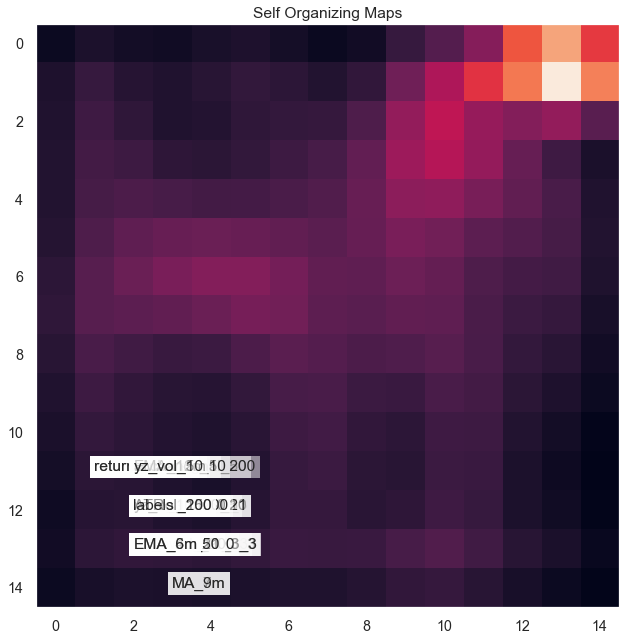

In [63]:
# Plot SOM
plt.figure(figsize=(20, 10))
for ix in range(len(df.columns)):
    winner = som.winner(X[ix])
    plt.text(winner[0], winner[1], df.columns[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps');

In [29]:
# List the corresponding features

for ix in range(len(df.columns)):
    winner = som.winner(X[ix])
    print(winner[0], winner[1], df.columns[ix])

2 12 Open
2 12 High
2 12 Low
2 12 Close
2 12 price
2 12 Volume
2 12 return
2 12 return_2d
2 12 return_3d
2 12 return_1w
2 12 return_2w
2 12 return_3w
2 12 return_1m
2 12 return_5w
1 11 return_6w
1 11 return_7w
1 11 return_2m
1 11 return_9w
1 11 return_10w
1 11 return_3m
1 11 return_15w
1 11 return_4m
1 11 return_18w
1 11 return_5m
2 12 return_6m
2 12 return_7m
2 13 return_8m
2 12 return_9m
2 13 return_10m
2 13 return_11m
2 13 return_12m
2 13 MA_2d
2 13 MA_5d
2 13 MA_10d
2 13 MA_15d
2 13 MA_1m
2 13 MA_2m
2 13 MA_3m
3 14 MA_4m
2 13 MA_5m
2 13 MA_6m
3 14 MA_7m
2 13 MA_8m
3 14 MA_9m
2 13 MA_10m
2 13 MA_11m
2 13 MA_12m
2 13 rsi_5
2 13 rsi_10
2 12 rsi_21
2 12 rsi_50
2 12 rsi_200
2 12 rsi_250
2 12 STOCHk_5_3_3
2 13 STOCHd_5_3_3
2 13 STOCHk_10_3_3
2 13 STOCHd_10_3_3
2 13 STOCHk_21_3_3
2 13 STOCHd_21_3_3
2 13 cci_5
2 13 cci_10
2 12 cci_21
2 12 cci_50
2 12 cci_200
2 12 macd_signal_5
2 12 macd_signal_10
2 12 macd_signal_21
2 11 macd_signal_50
2 11 macd_signal_200
2 11 accbands_5
2 11 accbands_10


Summary- given large number of features it's little hard to directly see the mapping visually. but by looking at the mapping we can see that
features which are similar in nature get mapped together 

# 6 KMeans

# KMeans Algorithm

The k-means algorithm searches for a predetermined number of clusters within an unlabeled dataset and is based on the assumptions that the optimal cluster will have “cluster center” which is the mean of all the points belonging to the cluster.
each point is closer to its own cluster center than to other cluster centers. Conventional k-means algorithm requires only a few steps and follows a two-step process called Expectation-Maximization approach. This consists of

Randomly selecting k-centroids or cluster center <br>
Repeat until converged <br>
a. E-Step: assign points to the nearest cluster center <br>
b. M-Step: set the cluster center to the mean <br>

The "E-Step" or "Expectation Step" assigns each data point to its nearest centroid. Then, the "M-Step" or Maximization Step" computes the mean of all the points for each cluster and sets the new centroid. The 

k-means algorithms seeks to find

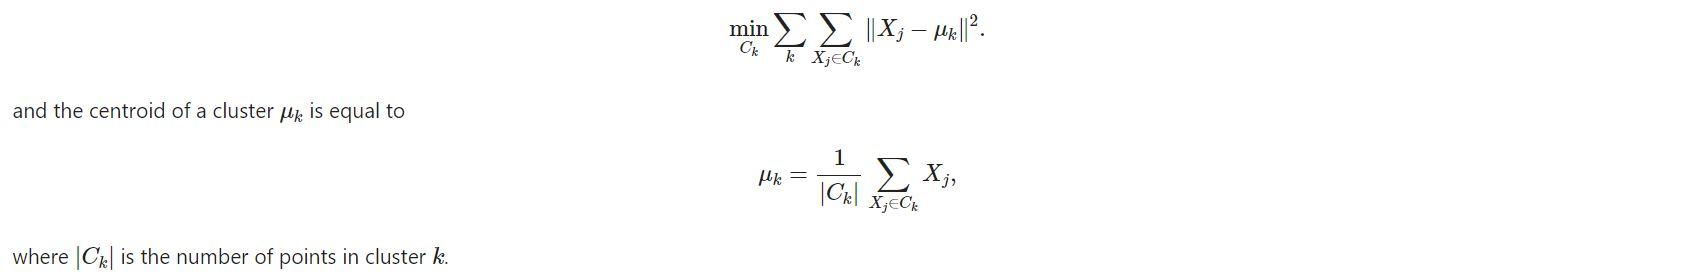

In [30]:
Image(filename='kmeans.JPG')

clusters within a data set. The clusters are chosen to reduce the inertia, the objective function


The cluster assignments are done based on squared Euclidean distance and algorithm tries to minimize the objective function. This process is repeated, iteratively, until the sum of the distance is minimized

In [31]:
# Import sklearn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

import yfinance as yf
from datetime import datetime

In [32]:
df.dropna(inplace=True)

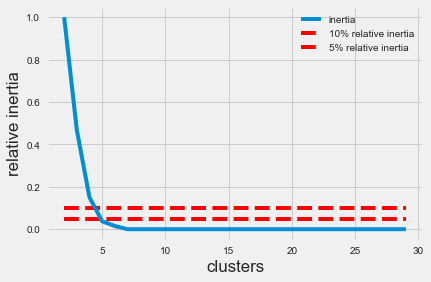

In [33]:
n_clusters = range(2, 30)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df.T)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]))
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

In [34]:
# Normalize and fit the model
pipe = Pipeline([("normalization", StandardScaler()), ("cluster", KMeans(n_clusters=15))])
# Fit Model
pipe.fit(df.T)

# Assign Label
labels = pipe.predict(df.T)
# Check lables
labels

array([ 9,  9,  9,  9,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  9,  9,
        9,  9, 13, 13, 13,  7,  7,  7,  7, 11, 11, 11, 11,  8,  8,  8,  8,
        8,  8, 12, 12, 12, 12, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  9,  9,  9, 13, 11,  4,  6,  1,  5,  3,  9,  9,  9,  9, 13, 13,
        7,  7, 11, 11, 11, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,
        0])

In [35]:
df_cluster = pd.DataFrame({'cluster': labels, 
                    'Features_name': df.columns}).sort_values(by=['cluster'], axis = 0)
df_cluster = df_cluster.reset_index(drop=True)
df_cluster

,cluster,Features_name
0,0,labels
1,0,return_6m
2,0,return_7m
3,0,return_8m
4,0,cci_10
5,0,return_10m
6,0,return_11m
7,0,return_12m
8,0,yz_vol_10
9,0,return_5m


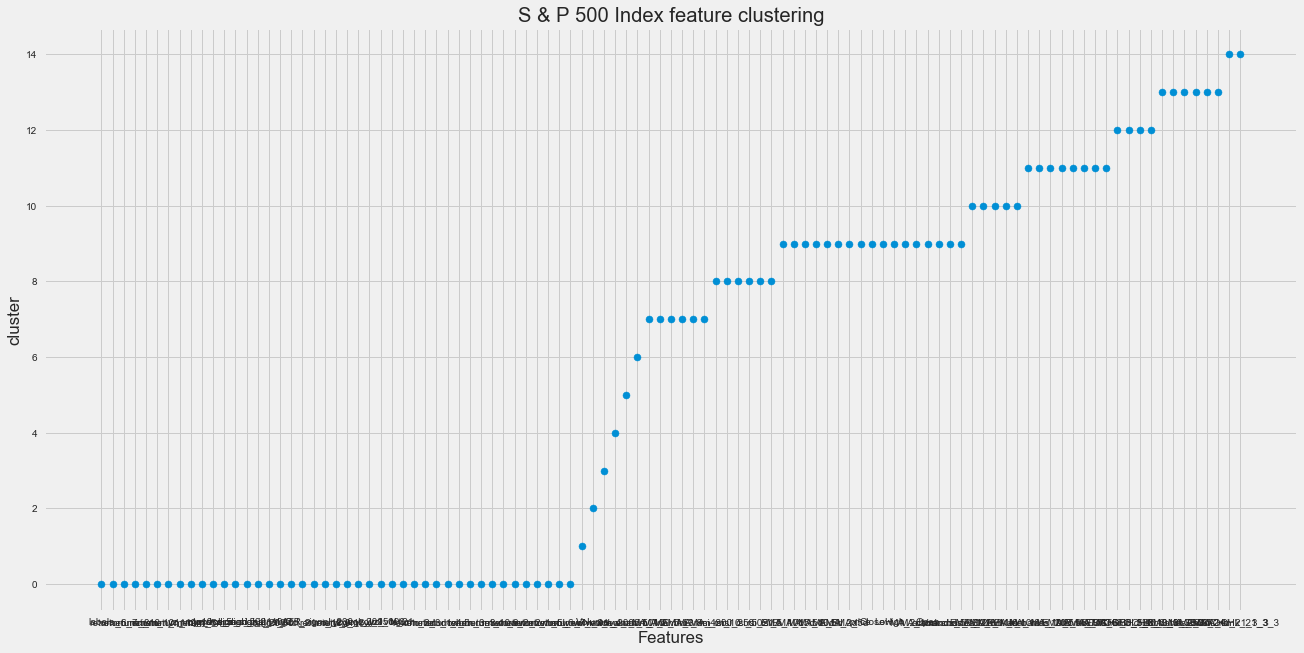

In [36]:
plt.figure(figsize=(20,10))
plt.scatter(df_cluster.Features_name, df_cluster.cluster)
plt.xlabel('Features')
plt.ylabel('cluster')
plt.title('S & P 500 Index feature clustering');

# 7 Decision Tree Classifier 

Decision Tree Algorithm

Select the best attribute using Attribute Selection Measures(ASM) to split the records. <br>
Make that attribute a decision node and breaks the dataset into smaller subsets. <br>
Starts tree building by repeating this process recursively for each child until one of the condition will match: <br>
All the tuples belong to the same attribute value. <br>
  * There are no more remaining attributes. <br>
  * There are no more instances. <br>

In [37]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [38]:
df.head()

,Open,High,Low,Close,price,Volume,return,return_2d,return_3d,return_1w,...,EMA_11m,EMA_12m,yz_vol_5,yz_vol_10,yz_vol_21,yz_vol_100,yz_vol_150,yz_vol_200,ATR,labels
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-12,326.440002,330.359985,326.440002,330.190002,330.190002,182270000,0.011488,0.003953,0.007445,0.000818,...,341.191838,342.249863,0.009448,0.014429,0.012146,0.021540,0.019414,0.017842,3.721428,1
1990-12-13,330.140015,330.579987,328.769989,329.339996,329.339996,162110000,-0.002574,0.008884,0.001368,0.000820,...,341.138210,342.196295,0.008395,0.013948,0.012330,0.021535,0.019261,0.017835,3.701904,1
1990-12-14,329.339996,329.339996,325.160004,326.820007,326.820007,151010000,-0.007652,-0.010206,0.001164,-0.002838,...,341.073422,342.132493,0.009768,0.011928,0.012491,0.021567,0.019254,0.017856,3.688094,1
1990-12-17,326.820007,326.820007,324.459991,326.019989,326.019989,118560000,-0.002448,-0.010081,-0.012629,-0.008726,...,341.005307,342.065636,0.010610,0.011765,0.012509,0.021565,0.019275,0.017863,3.597143,1
1990-12-18,326.019989,330.429993,325.750000,330.049988,330.049988,176460000,0.012361,0.009883,0.002156,0.011059,...,340.955735,342.015779,0.011798,0.010730,0.012627,0.021598,0.019301,0.017875,3.638572,1


In [39]:
y=df['labels']
X=df.drop(columns=['labels']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [40]:
#building classification tree with maximum depth equal to 4
clf = DecisionTreeClassifier(max_depth =4, random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

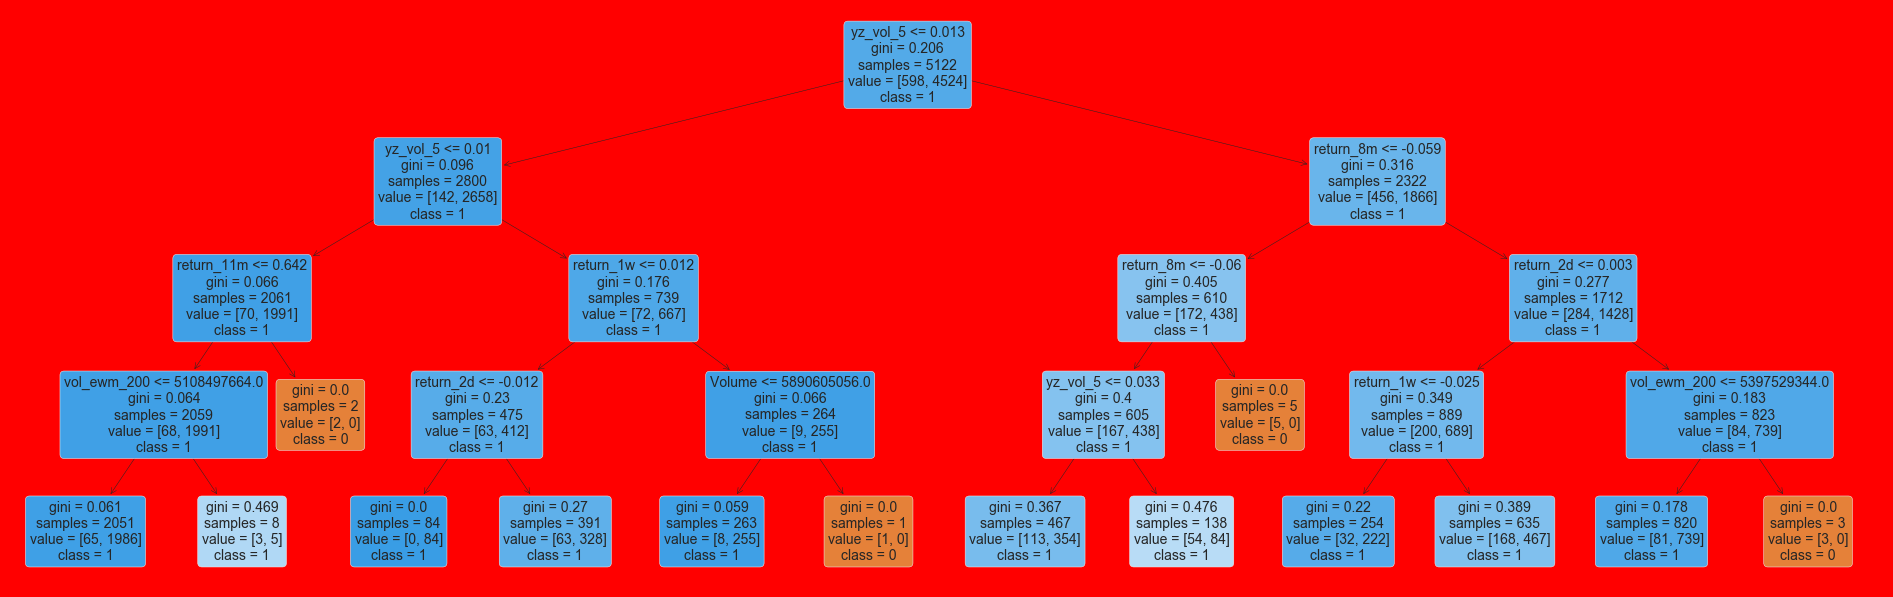

In [41]:
#import relevant packages
from sklearn import tree
import matplotlib.pyplot as plt
#plt the figure, setting a red background
plt.figure(figsize=(30,10), facecolor ='r')
#create the tree plot
a = tree.plot_tree(clf,feature_names = df.columns,class_names = ["0","1"],rounded = True,filled = True,fontsize=14)
#show the plot
plt.show()

In [42]:
#import relevant functions
from sklearn.tree import export_text
#export the decision rules
tree_rules = export_text(clf,feature_names = list(df.drop(columns=['labels']).columns))
#print the result
print(tree_rules)

|--- yz_vol_5 <= 0.01
|   |--- yz_vol_5 <= 0.01
|   |   |--- return_11m <= 0.64
|   |   |   |--- vol_ewm_200 <= 5108497664.00
|   |   |   |   |--- class: 1
|   |   |   |--- vol_ewm_200 >  5108497664.00
|   |   |   |   |--- class: 1
|   |   |--- return_11m >  0.64
|   |   |   |--- class: 0
|   |--- yz_vol_5 >  0.01
|   |   |--- return_1w <= 0.01
|   |   |   |--- return_2d <= -0.01
|   |   |   |   |--- class: 1
|   |   |   |--- return_2d >  -0.01
|   |   |   |   |--- class: 1
|   |   |--- return_1w >  0.01
|   |   |   |--- Volume <= 5890605056.00
|   |   |   |   |--- class: 1
|   |   |   |--- Volume >  5890605056.00
|   |   |   |   |--- class: 0
|--- yz_vol_5 >  0.01
|   |--- return_8m <= -0.06
|   |   |--- return_8m <= -0.06
|   |   |   |--- yz_vol_5 <= 0.03
|   |   |   |   |--- class: 1
|   |   |   |--- yz_vol_5 >  0.03
|   |   |   |   |--- class: 1
|   |   |--- return_8m >  -0.06
|   |   |   |--- class: 0
|   |--- return_8m >  -0.06
|   |   |--- return_2d <= 0.00
|   |   |   |--- retu

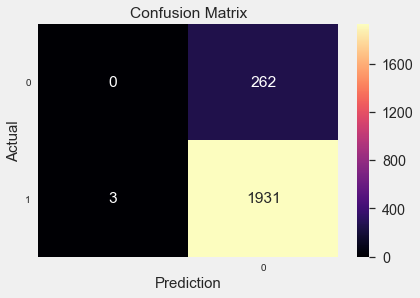

<Figure size 720x504 with 0 Axes>

In [43]:
# predict y for X test values
y_pred = clf.predict(X_test)

#import the relevant packages
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
#get the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
#turn this into a dataframe
df_matrix = pd.DataFrame(confusion_matrix)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(df_matrix, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix')
ax.set_xlabel("Prediction", fontsize =15)
ax.set_xticklabels(['']+["0","1"])
ax.set_ylabel("Actual", fontsize=15)
ax.set_yticklabels(["0","1"], rotation = 0)
plt.show()

In [44]:
# calculating the accuracy 
metrics.accuracy_score(y_test, y_pred)

0.8793260473588342

In [45]:
#get the precision score
precision = metrics.precision_score(y_test,y_pred, average=None)
#turn it into a dataframe
precision_results = pd.DataFrame(precision, index=["0","1"])
#rename the results column
precision_results.rename(columns={0:'precision'}, inplace =True)
precision_results

,precision
0,0.000000
1,0.880529


Summary- We know Decision Tree classifier is Supervised machine learning algorithms. again we can use it to club features which 
help predict same score say 0 or 1

# 8 Long Short-term Memory (LSTM) 

In [46]:
# function to generate time series sequence 
def generate_data(data, window_size):
    n = len(data)
    y = data.loc[window_size:,'labels'].copy()
    data.drop(columns="labels")
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size=60
df["labels"]=np.where(df['price'].shift(-1)>0.99*df['price'],1,0)
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df)
data = pd.DataFrame(data_scaled,columns=df.columns).copy()
X,y=generate_data(data, window_size)

training_len=int(len(X)*0.7)
# split the data for training and testing LSTM model 
X_train = X[:training_len].values.reshape(-1, window_size, 1)
y_train = y[:training_len]

# keep the last five year for testing
X_test = X[training_len:].values.reshape(-1, window_size, 1)
y_test = y[training_len:]

# assign variables for lstm 
batch, timesteps, features = X_train.shape
batch, timesteps, features

(5080, 60, 1)

In [59]:
# base model with 100 units 
model = Sequential()
model.add(LSTM(units=100, input_shape=(timesteps, features), activation = 'relu', name='LSTM'))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

model_path = (results_path / 'model.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [ ]:
lstm_training = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=100, 
                    verbose=1, 
                    callbacks=[early_stopping, checkpointer],
                    validation_data=(X_test, y_test), shuffle=False)

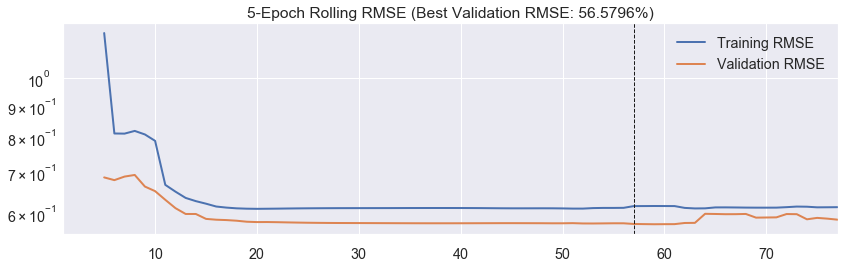

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))

# derive rmse for the training/validation loss
loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1

# get the best rmse and iteration of the same
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()

# plot rolling 5-iteration rmse
loss_history.columns=['Training RMSE', 'Validation RMSE']
title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

# location of best iteration
ax.axvline(best_epoch, ls='--', lw=1, c='k')

# save figure
fig.tight_layout()
#fig.savefig(results_path / 'lstm_error', dpi=300);

In [54]:
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.6195 | Test RMSE: 0.5658


In [55]:
y_pred=pd.Series(np.where(model.predict(X_test)>0.5,1,0).ravel())
accuracy_score(y_test, y_pred)

0.9072543617998163

# 8.1 Multi layer model with dropout 

In [ ]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(timesteps, features), activation = 'relu',return_sequences=True, name='LSTM'))
model.add(Dropout(0.2))
model.add(LSTM(units=50, input_shape=(timesteps, features), activation = 'relu', name='hidden'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

model_path = (results_path / 'model.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
lstm_training = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=100, 
                    verbose=1, 
                    callbacks=[early_stopping, checkpointer],
                    validation_data=(X_test, y_test), shuffle=False)


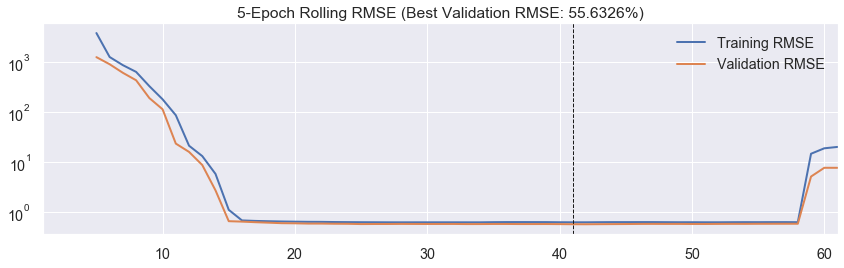

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))

# derive rmse for the training/validation loss
loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1

# get the best rmse and iteration of the same
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()

# plot rolling 5-iteration rmse
loss_history.columns=['Training RMSE', 'Validation RMSE']
title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

# location of best iteration
ax.axvline(best_epoch, ls='--', lw=1, c='k')

# save figure
fig.tight_layout()
#fig.savefig(results_path / 'lstm_error', dpi=300);

# 8.2 Grid Search

selecting the best optimizer

In [57]:
# Function to create model, required for KerasClassifier
def lstm_model(optimizer='adam'):
# create model
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(timesteps, features), activation = 'relu', name='LSTM'))
    model.add(Dense(units=1, activation="sigmoid"))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=lstm_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.871850 using {'optimizer': 'SGD'}
0.871850 (0.031693) with: {'optimizer': 'SGD'}
0.871850 (0.031693) with: {'optimizer': 'Adam'}


# 9 Conclusion 

In this project I have learned a lot in terms of applying the state of the art technique to one of the most challenging problems in the financial industry.
I was able to build good set of features which include but not limited to financial ratios, advance technical indicators, and drift independent vols. then I have applied few unsupervised and supervised machine learning algorithms like Kmeans, SOM, and Decision Tree Classifier (DTC) and observed quite a few interesting observations.
in the next step built base LSTM model with one hidden layer using 100 nodes on the complete set of features and it generated pretty good results, also tested adding more hidden layers and changing the nodes in each layer along with dropout and early stopping. 
when we have more hidden layers of course the results do improve but then it comes with extra time complexity.

I have tested the program with multiple variables through grid search- batch size, epoch, optimizer, learning rate, and many more(I have not included few grid search codes here as they were really really time consuming). finally I decided to keep simple and the most elegent program for LSTM.

Overall it was great learning throughout this Master's program, I would like to thank you! each and everyone who is involved and made this happen!
I will be continuing my learning in future!!

# 10 References

[1] [minisom]("https://github.com/JustGlowing/minisom") <br>
[2] [preprocessing]("https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html") <br>
[3] [Keras]("https://keras.io/") <br>
[4] [Kmeans]("https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html") <br>
[5] [Scikit-learn API Reference]("https://scikit-learn.org/stable/modules/classes.html") <br>
[6] [Machine Learning]("https://machinelearningmastery.com/") <br>
[7] [Data Science Medium]("https://towardsdatascience.com/")  <br>
[8] [Data Camp]("https://www.datacamp.com/") <br>
[9] Andrej Karpathy (2015), The Unreasonable Effectiveness of Recurrent Neural Networks <br>
[10] Francois Chollet (2019), Deep Learning with Python <br>
[11] Jake VanderPlas (2017), Python Data Science Handbook <br>
